In [97]:
import pandas as pd
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy.stats.mstats import winsorize

In [3]:
ds = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv").iloc[:,1:]
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', None)

ds.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365
3,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
ds.shape

(48895, 15)

In [5]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month               

In [6]:
# Porcentaje de valores Nan

ds.isna().sum() / len(ds) *100

name                               0.03
host_id                            0.00
host_name                          0.04
neighbourhood_group                0.00
neighbourhood                      0.00
latitude                           0.00
longitude                          0.00
room_type                          0.00
price                              0.00
minimum_nights                     0.00
number_of_reviews                  0.00
last_review                       20.56
reviews_per_month                 20.56
calculated_host_listings_count     0.00
availability_365                   0.00
dtype: float64

In [7]:
ds.loc[:,"reviews_per_month"]

0        0.21
1        0.38
2         NaN
3        4.64
4        0.10
         ... 
48890     NaN
48891     NaN
48892     NaN
48893     NaN
48894     NaN
Name: reviews_per_month, Length: 48895, dtype: float64

"Last Review" y "Reviews per Month" tienen muchos valores faltantes. Last Review no considero que tenga valor predictivo 

Procedo a eliminar:

In [8]:
ds.drop(["last_review"], axis = 1, inplace=True)

ds.shape

(48895, 14)

Conteo de valores únicos por columna

In [9]:
ds.nunique()

name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [10]:
print(f"Duplicados de Host_id: {ds['host_id'].duplicated().sum()}")
print(f"Filas idénticas en el DataSet: {ds.duplicated().sum()}")


Duplicados de Host_id: 11438
Filas idénticas en el DataSet: 0


Elimino variables con duplicados y sin valor predictivo:

In [11]:
ds.drop(["name","host_name"], axis=1, inplace=True)

In [12]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_id                         48895 non-null  int64  
 1   neighbourhood_group             48895 non-null  object 
 2   neighbourhood                   48895 non-null  object 
 3   latitude                        48895 non-null  float64
 4   longitude                       48895 non-null  float64
 5   room_type                       48895 non-null  object 
 6   price                           48895 non-null  int64  
 7   minimum_nights                  48895 non-null  int64  
 8   number_of_reviews               48895 non-null  int64  
 9   reviews_per_month               38843 non-null  float64
 10  calculated_host_listings_count  48895 non-null  int64  
 11  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(6), object(

In [13]:
ds.describe()


,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.89e+04,48895.00,48895.00,48895.00,48895.00,48895.00,38843.00,48895.00,48895.00
mean,6.76e+07,40.73,-73.95,152.72,7.03,23.27,1.37,7.14,112.78
std,7.86e+07,0.05,0.05,240.15,20.51,44.55,1.68,32.95,131.62
min,2.44e+03,40.50,-74.24,0.00,1.00,0.00,0.01,1.00,0.00
25%,7.82e+06,40.69,-73.98,69.00,1.00,1.00,0.19,1.00,0.00
50%,3.08e+07,40.72,-73.96,106.00,3.00,5.00,0.72,1.00,45.00
75%,1.07e+08,40.76,-73.94,175.00,5.00,24.00,2.02,2.00,227.00
max,2.74e+08,40.91,-73.71,10000.00,1250.00,629.00,58.50,327.00,365.00


Imputación de Valores Faltantes para "Reviews_per_month". 
Solo para probar el imputador.


In [14]:
imputer = KNNImputer()

# Me salió un error al qurer pasar unicamente una columna, por lo que debo usar un Reshape
rev_bidimensional = ds["reviews_per_month"].values.reshape(-1, 1)

ds["reviews_per_month"] = imputer.fit_transform(rev_bidimensional)

print(ds["reviews_per_month"].isna().sum())


0


In [15]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_id                         48895 non-null  int64  
 1   neighbourhood_group             48895 non-null  object 
 2   neighbourhood                   48895 non-null  object 
 3   latitude                        48895 non-null  float64
 4   longitude                       48895 non-null  float64
 5   room_type                       48895 non-null  object 
 6   price                           48895 non-null  int64  
 7   minimum_nights                  48895 non-null  int64  
 8   number_of_reviews               48895 non-null  int64  
 9   reviews_per_month               48895 non-null  float64
 10  calculated_host_listings_count  48895 non-null  int64  
 11  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(6), object(

Análisis Univariante sobre variables categóricas.

Para representar este tipo de variables utilizaremos histogramas.


Variables Categóricas =  host_id,  neighbourhood_group,  neighbourhood,  room_type,  availability_365


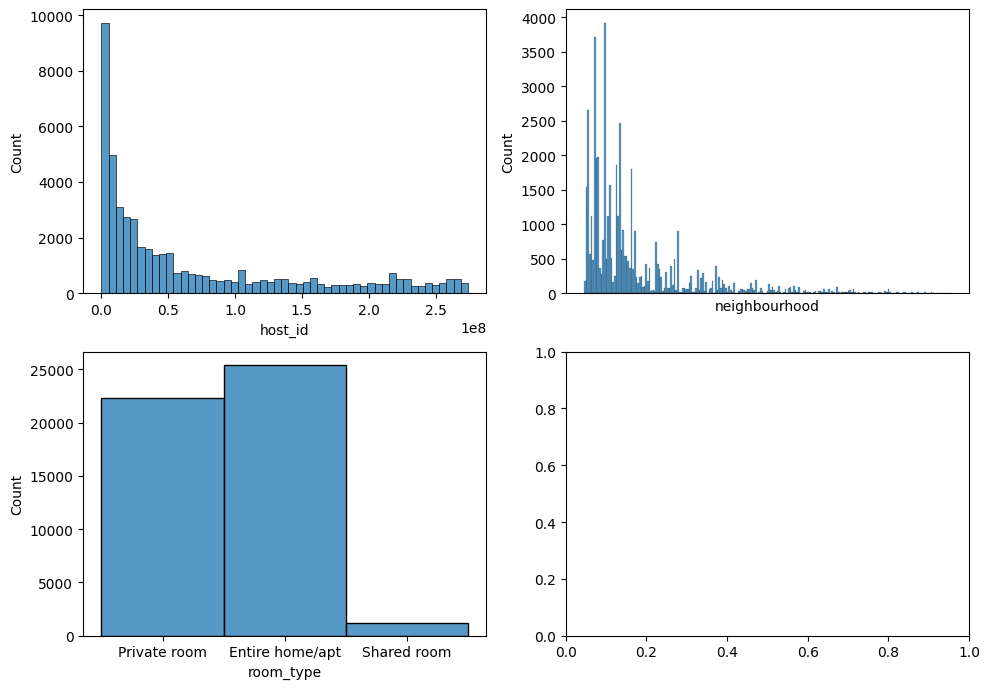

In [16]:
fig, axis = plt.subplots(2, 2, figsize = (10, 7))

# Crear un histograma múltiple
sns.histplot(ax = axis[0, 0], data = ds, x = "host_id")
sns.histplot(ax = axis[0, 1], data = ds, x = "neighbourhood").set_xticks([])
sns.histplot(ax = axis[1, 0], data = ds, x = "room_type")






# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

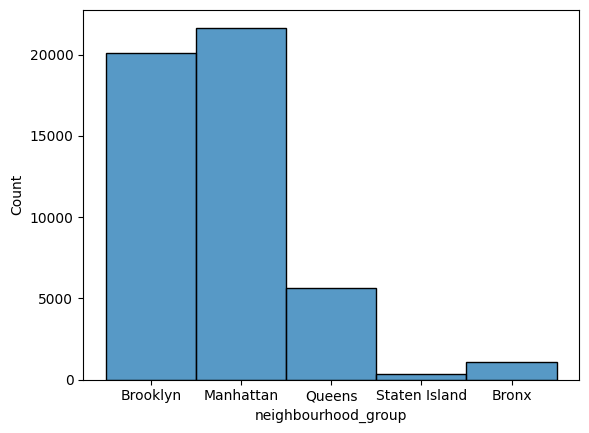

In [17]:
sns.histplot(data = ds, x = "neighbourhood_group")
plt.show()

In [18]:
ds["host_id"].value_counts()

host_id
219517861    327
107434423    232
30283594     121
137358866    103
16098958      96
            ... 
23727216       1
89211125       1
19928013       1
1017772        1
68119814       1
Name: count, Length: 37457, dtype: int64

In [19]:
ds[ds["host_id"] == 0].count()

host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

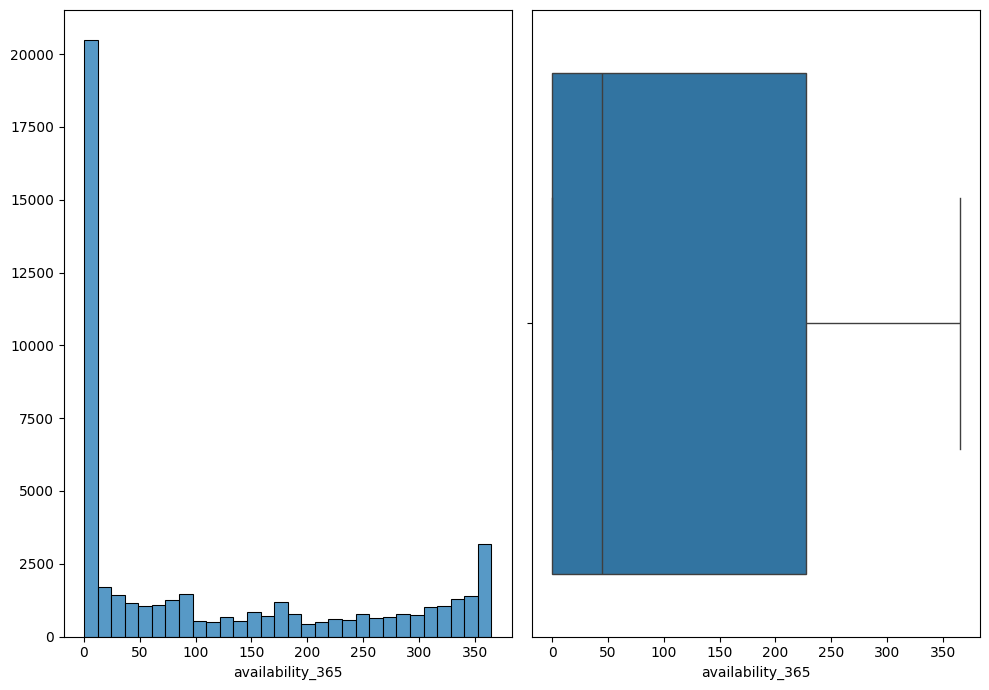

In [20]:
# availability_365

fig, axis = plt.subplots (1, 2, figsize=(10,7))

sns.histplot(ax = axis[0], data = ds, x = "availability_365").set(ylabel = None)
sns.boxplot(ax = axis[1], x=ds["availability_365"])

plt.tight_layout()
plt.show()

In [21]:
ds["availability_365"].describe()

count    48895.00
mean       112.78
std        131.62
min          0.00
25%          0.00
50%         45.00
75%        227.00
max        365.00
Name: availability_365, dtype: float64

In [22]:
ds[ds["availability_365"] == 0]

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
4,7192,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,0.10,1,0
6,7356,Brooklyn,Bedford-Stuyvesant,40.69,-73.96,Private room,60,45,49,0.40,1,0
8,7490,Manhattan,Upper West Side,40.80,-73.97,Private room,79,2,118,0.99,1,0
14,11975,Manhattan,West Village,40.74,-74.01,Entire home/apt,120,90,27,0.22,1,0
20,21207,Brooklyn,Williamsburg,40.72,-73.96,Entire home/apt,299,3,9,0.07,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
48550,16883913,Queens,Ridgewood,40.70,-73.90,Private room,45,1,0,1.37,1,0
48731,121384174,Brooklyn,Park Slope,40.67,-73.98,Entire home/apt,111,8,0,1.37,1,0
48756,273824202,Manhattan,Murray Hill,40.74,-73.97,Entire home/apt,129,2,0,1.37,1,0
48760,19990280,Queens,Sunnyside,40.75,-73.92,Private room,46,1,0,1.37,1,0


La variable Host_Id no nos revela mucha información. Cómo única conclusión, sabemos que varios hosts tienen más de una publicación.

La variable availability_365 tiene muchos valores igual a 0, lo que se puede interpretar como valores faltantes. 
De los registros que reflejan un valor para esta variable, la moda es 365.

La variable room_type reflaja que la mayor parte de las publicaciones son de pisos enteros, seguido por habitaciones privadas y en mucho menor medida habitaciones compartidas. 

En la distribución de la variable neighbourhood_group, se ve que la mayor parte de las puublicaciones son de Manhattan y luego en Brokklyn. El resto (Queens, Staten Island y Bronx) en menor medida. 





Análisis Univariante sobre variables numéricas.

Para representar este tipo de variables utilizaremos histogramas.


Variables Categóricas =  latitude, longitude, price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count

<function matplotlib.pyplot.show(close=None, block=None)>

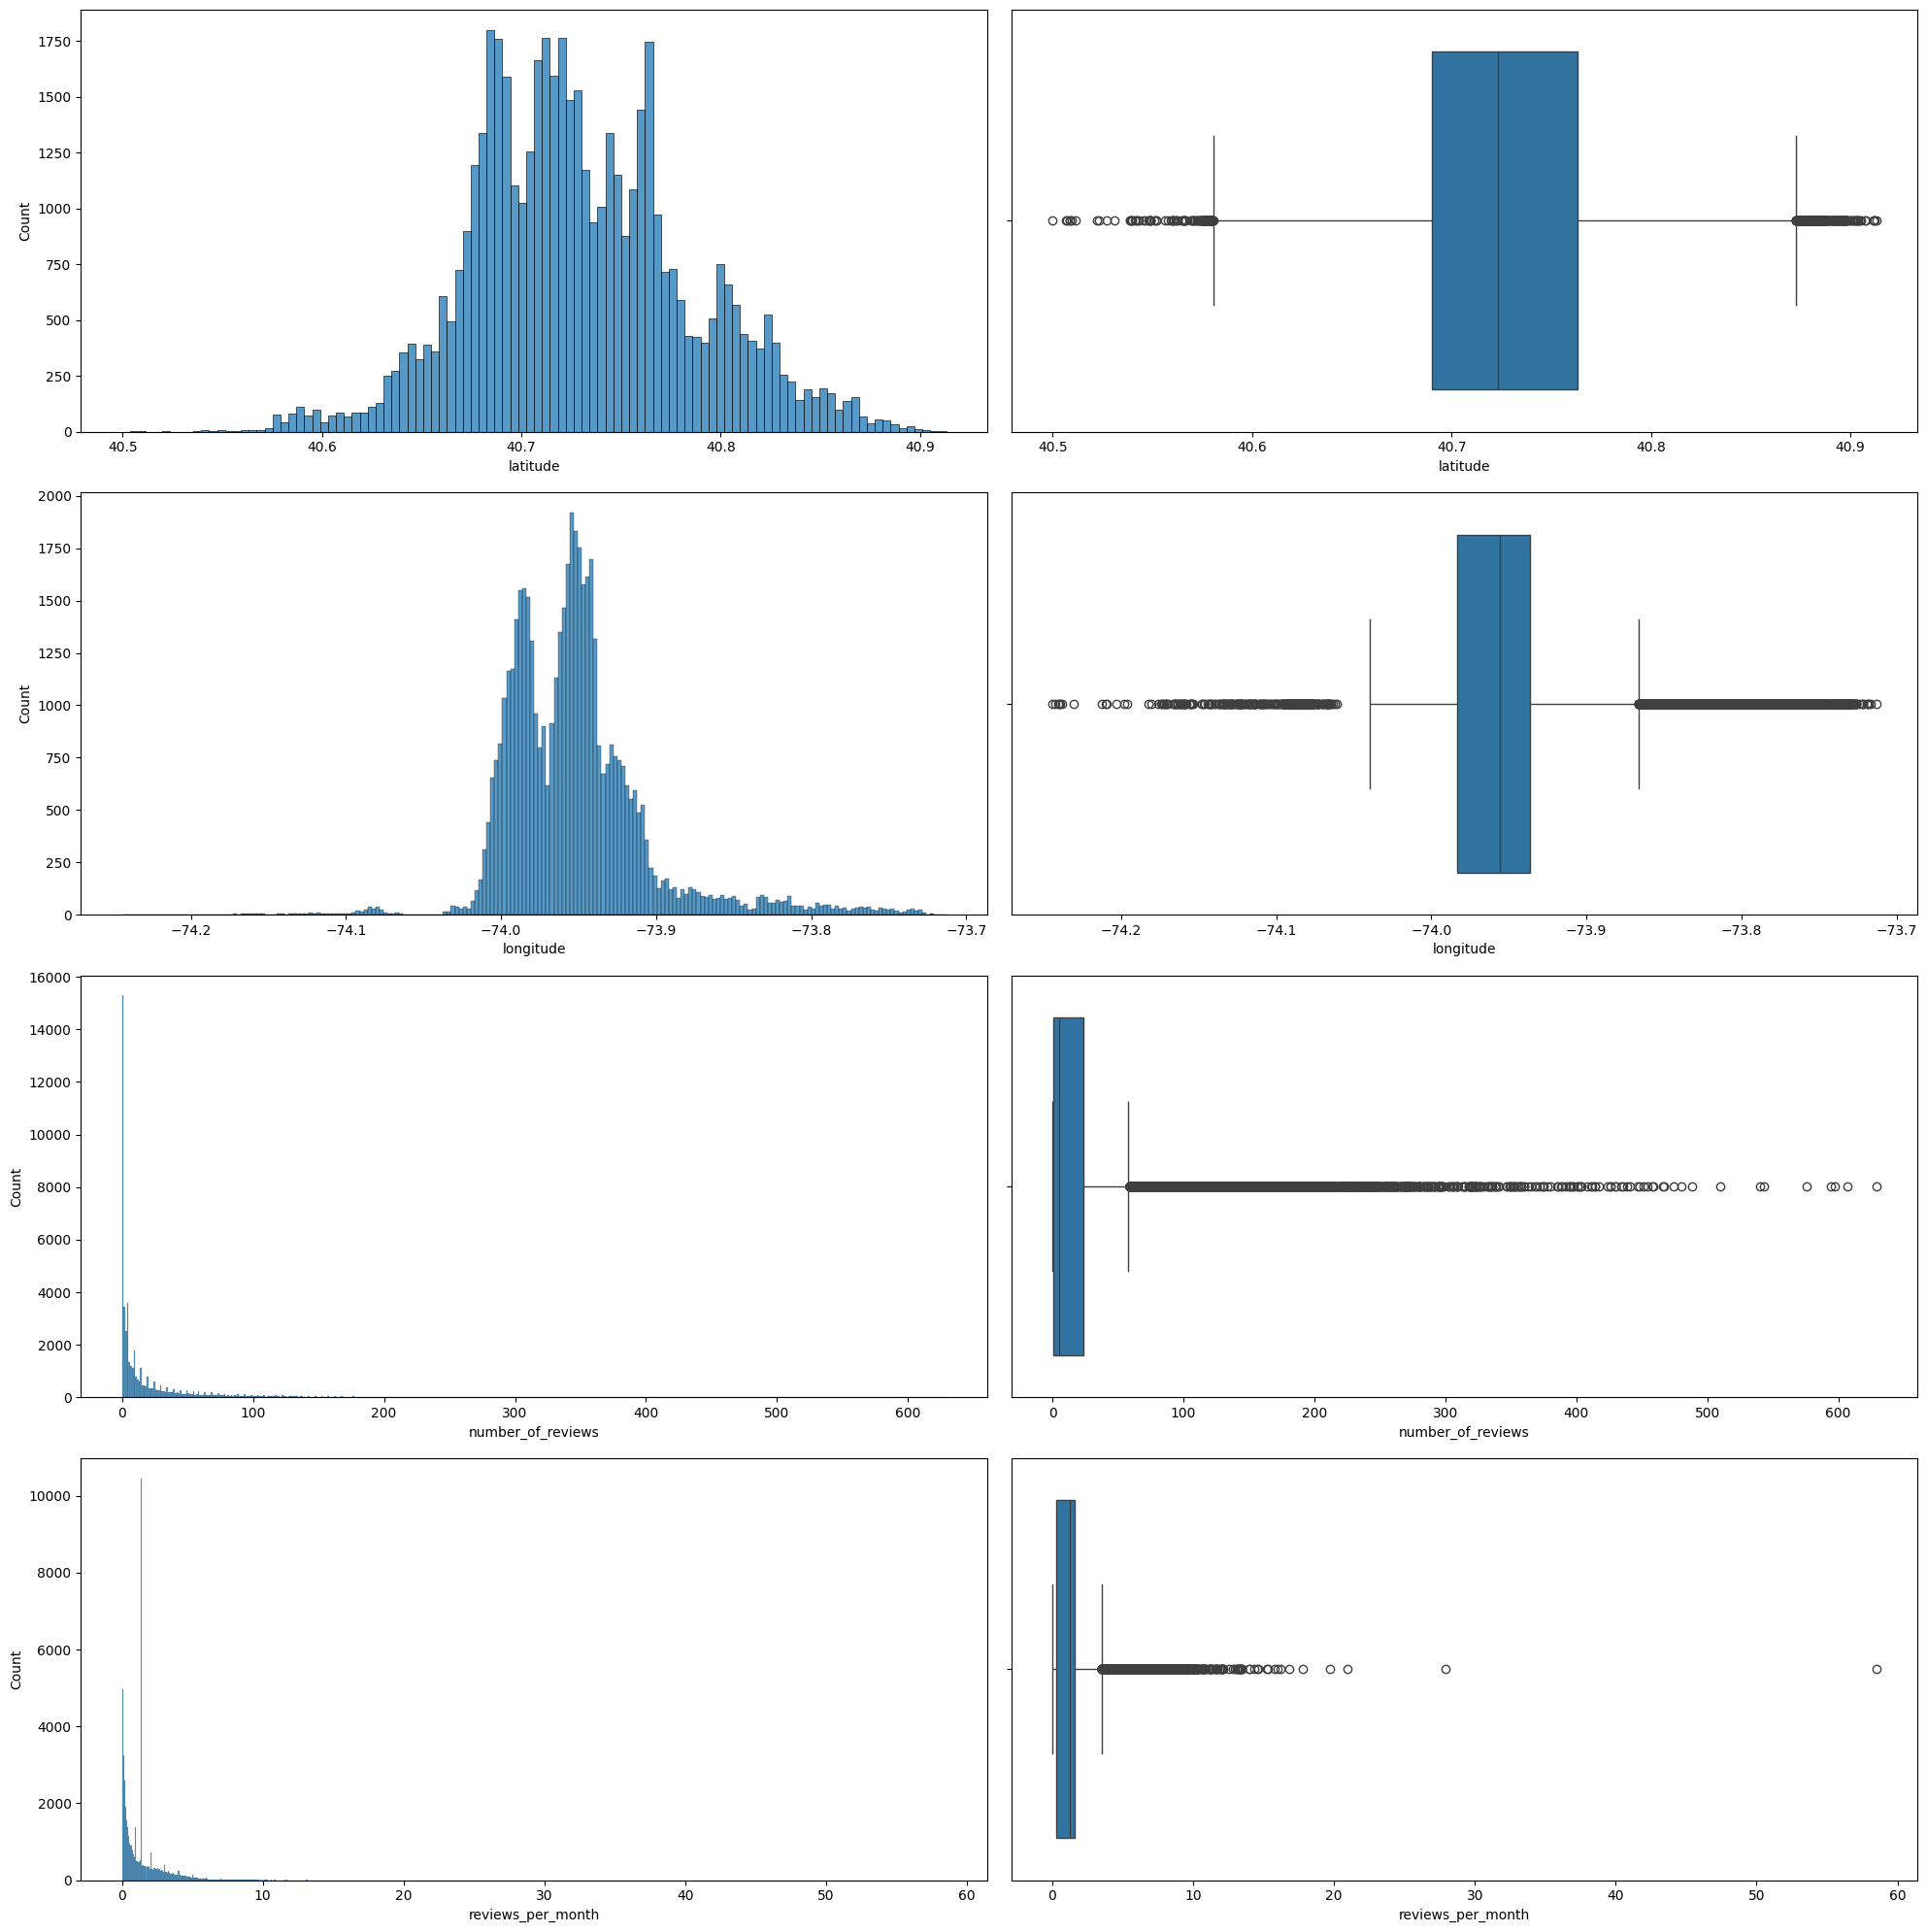

In [23]:
fig, axis = plt.subplots(4, 2, figsize=(20,20))

sns.histplot(ax=axis[0,0], data= ds, x= "latitude")
sns.boxplot(ax=axis[0,1], data=ds, x="latitude")

sns.histplot(ax=axis[1,0], data= ds, x= "longitude")
sns.boxplot(ax=axis[1,1], data=ds, x="longitude")

sns.histplot(ax=axis[2,0], data= ds, x= "number_of_reviews")
sns.boxplot(ax=axis[2,1], data=ds, x="number_of_reviews")

sns.histplot(ax=axis[3,0], data= ds, x= "reviews_per_month")
sns.boxplot(ax=axis[3,1], data=ds, x="reviews_per_month")

plt.tight_layout()
plt.show

In [24]:
ds[["latitude", "longitude", "number_of_reviews", "reviews_per_month"]].describe()

,latitude,longitude,number_of_reviews,reviews_per_month
count,48895.00,48895.00,48895.00,48895.00
mean,40.73,-73.95,23.27,1.37
std,0.05,0.05,44.55,1.50
min,40.50,-74.24,0.00,0.01
25%,40.69,-73.98,1.00,0.28
50%,40.72,-73.96,5.00,1.22
75%,40.76,-73.94,24.00,1.58
max,40.91,-73.71,629.00,58.50


In [25]:
ds["number_of_reviews"].idxmax()
ds.loc[11759]

host_id                               47621202
neighbourhood_group                     Queens
neighbourhood                          Jamaica
latitude                                 40.67
longitude                               -73.77
room_type                         Private room
price                                       47
minimum_nights                               1
number_of_reviews                          629
reviews_per_month                        14.58
calculated_host_listings_count               2
availability_365                           333
Name: 11759, dtype: object

In [26]:
ds["reviews_per_month"].idxmax()
ds.iloc[42075]

host_id                                  244361589
neighbourhood_group                      Manhattan
neighbourhood                     Theater District
latitude                                     40.76
longitude                                   -73.99
room_type                             Private room
price                                          100
minimum_nights                                   1
number_of_reviews                              156
reviews_per_month                             58.5
calculated_host_listings_count                   9
availability_365                               299
Name: 42075, dtype: object

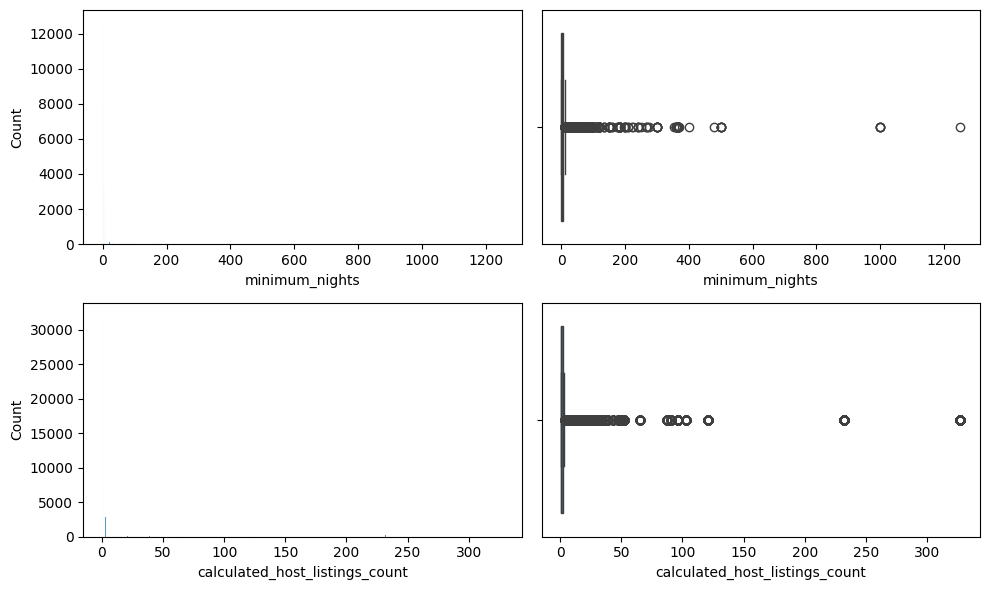

In [27]:
# price, minimum_nights calculated_host_listings_count

fig, axis = plt.subplots(2, 2, figsize=(10,6))

sns.histplot(ax=axis[0,0], data= ds, x= "minimum_nights")
sns.boxplot(ax=axis[0,1], data=ds, x="minimum_nights")

sns.histplot(ax=axis[1,0], data= ds, x= "calculated_host_listings_count")
sns.boxplot(ax=axis[1,1], data=ds, x="calculated_host_listings_count")


plt.tight_layout()
plt.show()

In [28]:
ds[["minimum_nights", "calculated_host_listings_count"]].describe()

,minimum_nights,calculated_host_listings_count
count,48895.00,48895.00
mean,7.03,7.14
std,20.51,32.95
min,1.00,1.00
25%,1.00,1.00
50%,3.00,1.00
75%,5.00,2.00
max,1250.00,327.00


In [29]:
ds[["minimum_nights", "calculated_host_listings_count"]].nunique()

minimum_nights                    109
calculated_host_listings_count     47
dtype: int64

Observaciones de Variables Numéricas: 

Latitud y Longitud presentan una aparente distribución normal y ambos cuentan con a presencias de outliers.

Number of Reviews y Reviews_per_Month tienen muchos valores extremos y muchos valores = 0, que de igual forma se asume como la ausencias de Reviews más que como Nan. 

Calculated_host_listings_count y Minimum nights tienen una media similar (= 7) pero ambos cuentan con la presencia de Outliers por ser una variable continua.

Análisis de Price: 

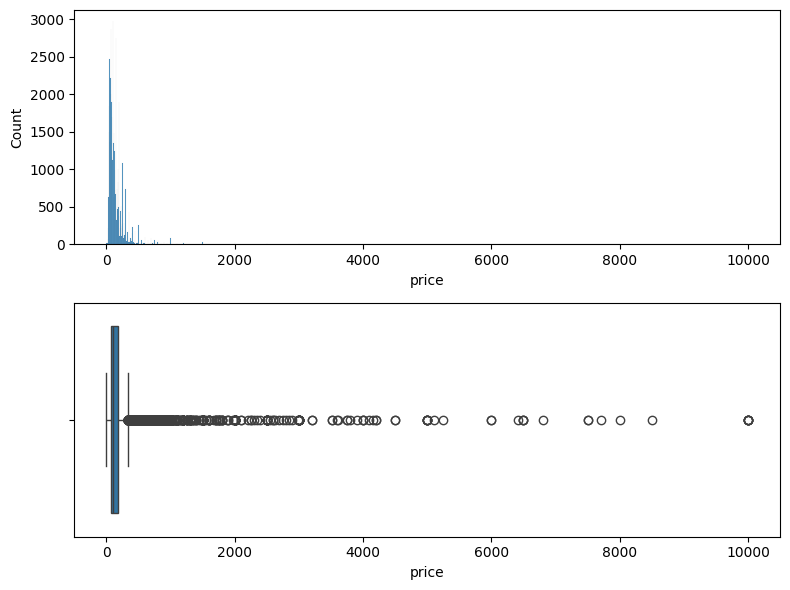

In [30]:
fig, axis = plt.subplots(2, figsize=(8,6))

sns.histplot(ax=axis[0], data= ds, x= "price")
sns.boxplot(ax=axis[1], data=ds, x="price")

plt.tight_layout()
plt.show()

In [31]:
ds["price"].describe()

count    48895.00
mean       152.72
std        240.15
min          0.00
25%         69.00
50%        106.00
75%        175.00
max      10000.00
Name: price, dtype: float64

In [32]:
ds[ds["price"] == 0]

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
23161,8993084,Brooklyn,Bedford-Stuyvesant,40.69,-73.95,Private room,0,4,1,0.05,4,28
25433,131697576,Bronx,East Morrisania,40.83,-73.89,Private room,0,2,55,2.56,4,127
25634,15787004,Brooklyn,Bushwick,40.69,-73.92,Private room,0,2,16,0.71,5,0
25753,1641537,Brooklyn,Greenpoint,40.72,-73.94,Private room,0,2,12,0.53,2,0
25778,10132166,Brooklyn,Williamsburg,40.71,-73.95,Entire home/apt,0,5,3,0.15,1,73
25794,86327101,Brooklyn,Bedford-Stuyvesant,40.68,-73.91,Private room,0,1,93,4.28,6,176
25795,86327101,Brooklyn,Bedford-Stuyvesant,40.68,-73.91,Private room,0,1,95,4.37,6,232
25796,86327101,Brooklyn,Bedford-Stuyvesant,40.68,-73.91,Private room,0,1,95,4.35,6,222
26259,13709292,Manhattan,Murray Hill,40.75,-73.98,Entire home/apt,0,3,0,1.37,1,0
26841,101970559,Brooklyn,Bushwick,40.69,-73.91,Shared room,0,30,2,0.11,6,333


In [33]:
print(f"El skew del precio es {round(ds['price'].skew(),2)}")

El skew del precio es 19.12


La desviación estándar es bastante alta en relación con la media (240.15). Esto sugiere que los precios tienen una amplia dispersión alrededor de la media, lo que indica una gran variabilidad en los precios.

Hay 11 valor de "price" == 0 lo que puede sugerir que son valores NaN.

Hay muchos valores atípicos con tendencia hacia la derecha. El skew de 19.12 confirma que existe una asimetría extrema en la distribución de los precios.


Análisis Multivariable: 

Variables numéricas = host_id, latitude, longitude, minimum_nights, number_of_reviews, availability_365, calculated_host_listings_count



Variables Categóricas = neighbourhood, room_type, neighbourhood_group

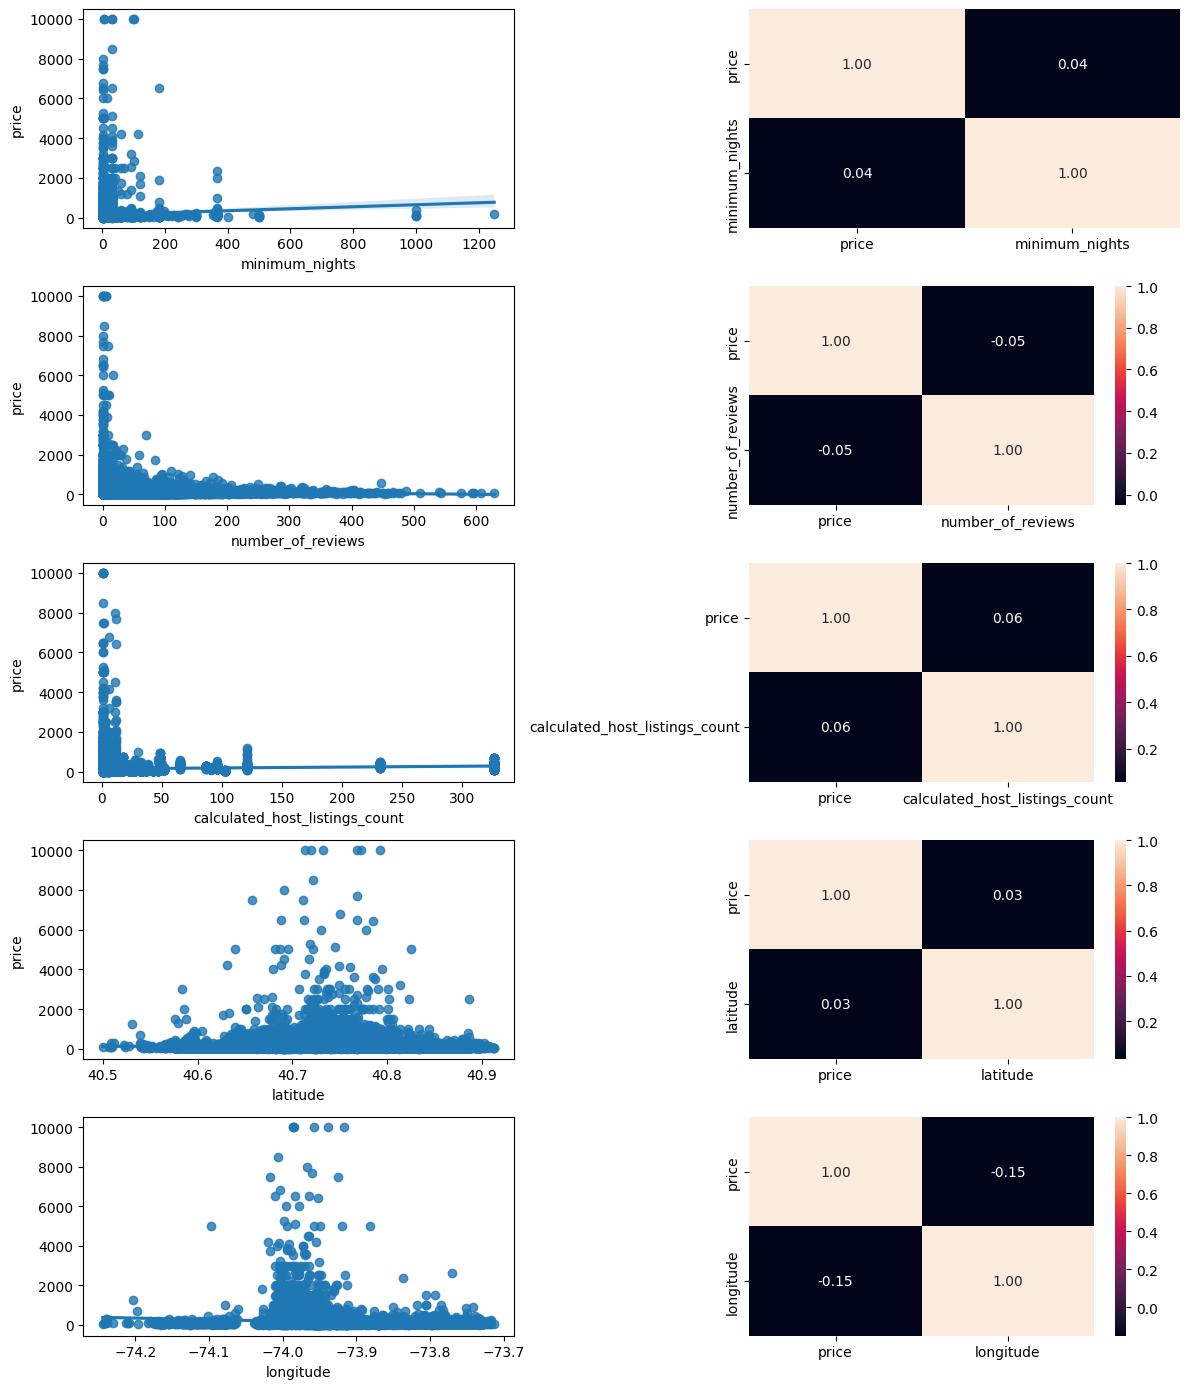

In [34]:
#Análisis numérico-numérico

fig, axis = plt.subplots(5, 2, figsize = (12, 14))

 
sns.regplot(ax = axis[0, 0], data = ds, x = "minimum_nights", y = "price")
sns.heatmap(ds[["price", "minimum_nights"]].corr(), annot = True, fmt = ".2f", ax = axis[0, 1], cbar = False)

sns.regplot(ax = axis[1, 0], data = ds, x = "number_of_reviews", y = "price")
sns.heatmap(ds[["price", "number_of_reviews"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

sns.regplot(ax = axis[2, 0], data = ds, x = "calculated_host_listings_count", y = "price")
sns.heatmap(ds[["price", "calculated_host_listings_count"]].corr(), annot = True, fmt = ".2f", ax = axis[2, 1]).set(ylabel = None)

sns.regplot(ax = axis[3, 0], data = ds, x = "latitude", y = "price")
sns.heatmap(ds[["price", "latitude"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 1]).set(ylabel = None)

sns.regplot(ax = axis[4, 0], data = ds, x = "longitude", y = "price").set(ylabel = None)
sns.heatmap(ds[["price", "longitude"]].corr(), annot = True, fmt = ".2f", ax = axis[4, 1]).set(ylabel = None)

plt.tight_layout()
plt.show()

No hay correlaciones significativas entre las variables numéricas y la variable objetivo

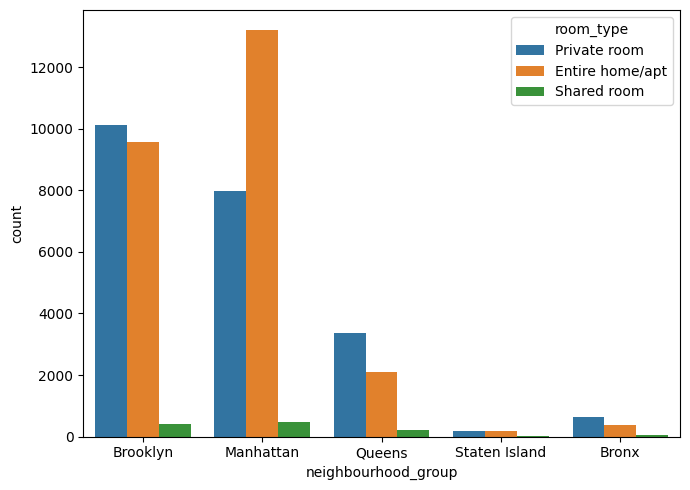

In [35]:
#Analisis categórico - categórico

fig, axis = plt.subplots(figsize = (7,5))

sns.countplot(data=ds, x="neighbourhood_group", hue="room_type")

plt.tight_layout()
plt.show()

Conclusiones: 

Manhattan y Brooklyn tienen el mayor número de publicaciones. 

En Manhattan la gran mayoría son de pisos enteros en alquiler, mientras que el alquiler de habitaciones es proporcionalmente más reducido. 

Brooklyn, al igual que el resto de localidades, tiene más habitaciones en alquiler que pisos enteros. 



In [36]:
# Uso de One-Hot Encodding para transformar las variables categóricas a números y poder hacer el análisis multivariante que corresponde. 
ds_categoricas_encoded = pd.get_dummies(ds, columns=["room_type", "neighbourhood_group"] )

ds_categoricas_encoded

,host_id,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
0,2787,Kensington,40.65,-73.97,149,1,9,0.21,6,365,False,True,False,False,True,False,False,False
1,2845,Midtown,40.75,-73.98,225,1,45,0.38,2,355,True,False,False,False,False,True,False,False
2,4632,Harlem,40.81,-73.94,150,3,0,1.37,1,365,False,True,False,False,False,True,False,False
3,4869,Clinton Hill,40.69,-73.96,89,1,270,4.64,1,194,True,False,False,False,True,False,False,False
4,7192,East Harlem,40.80,-73.94,80,10,9,0.10,1,0,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,8232441,Bedford-Stuyvesant,40.68,-73.95,70,2,0,1.37,2,9,False,True,False,False,True,False,False,False
48891,6570630,Bushwick,40.70,-73.93,40,4,0,1.37,2,36,False,True,False,False,True,False,False,False
48892,23492952,Harlem,40.81,-73.95,115,10,0,1.37,1,27,True,False,False,False,False,True,False,False
48893,30985759,Hell's Kitchen,40.76,-73.99,55,1,0,1.37,6,2,False,False,True,False,False,True,False,False


In [37]:
# Escalado de la Variable Objetivo: aplicamos la escala logarítmica a Price. 

# elimino los valores menores a 0 para poder aplicar .log()
ds = ds[ds["price"] > 0]

ds["log_price"] = np.log(ds["price"])


ds["log_price"].describe()

count    48884.00
mean         4.73
std          0.70
min          2.30
25%          4.23
50%          4.66
75%          5.16
max          9.21
Name: log_price, dtype: float64

In [38]:
ds_categoricas_encoded["log_price"] = ds["log_price"]
ds_categoricas_encoded

,host_id,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,log_price
0,2787,Kensington,40.65,-73.97,149,1,9,0.21,6,365,False,True,False,False,True,False,False,False,5.00
1,2845,Midtown,40.75,-73.98,225,1,45,0.38,2,355,True,False,False,False,False,True,False,False,5.42
2,4632,Harlem,40.81,-73.94,150,3,0,1.37,1,365,False,True,False,False,False,True,False,False,5.01
3,4869,Clinton Hill,40.69,-73.96,89,1,270,4.64,1,194,True,False,False,False,True,False,False,False,4.49
4,7192,East Harlem,40.80,-73.94,80,10,9,0.10,1,0,True,False,False,False,False,True,False,False,4.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,8232441,Bedford-Stuyvesant,40.68,-73.95,70,2,0,1.37,2,9,False,True,False,False,True,False,False,False,4.25
48891,6570630,Bushwick,40.70,-73.93,40,4,0,1.37,2,36,False,True,False,False,True,False,False,False,3.69
48892,23492952,Harlem,40.81,-73.95,115,10,0,1.37,1,27,True,False,False,False,False,True,False,False,4.74
48893,30985759,Hell's Kitchen,40.76,-73.99,55,1,0,1.37,6,2,False,False,True,False,False,True,False,False,4.01


In [39]:
ds_categoricas_encoded.columns

var_corr = ['log_price','minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'neighbourhood_group_Bronx',
       'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
       'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island']

ds_categoricas_encoded[var_corr]

,log_price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
0,5.00,1,9,6,365,False,True,False,False,True,False,False,False
1,5.42,1,45,2,355,True,False,False,False,False,True,False,False
2,5.01,3,0,1,365,False,True,False,False,False,True,False,False
3,4.49,1,270,1,194,True,False,False,False,True,False,False,False
4,4.38,10,9,1,0,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,4.25,2,0,2,9,False,True,False,False,True,False,False,False
48891,3.69,4,0,2,36,False,True,False,False,True,False,False,False
48892,4.74,10,0,1,27,True,False,False,False,False,True,False,False
48893,4.01,1,0,6,2,False,False,True,False,False,True,False,False


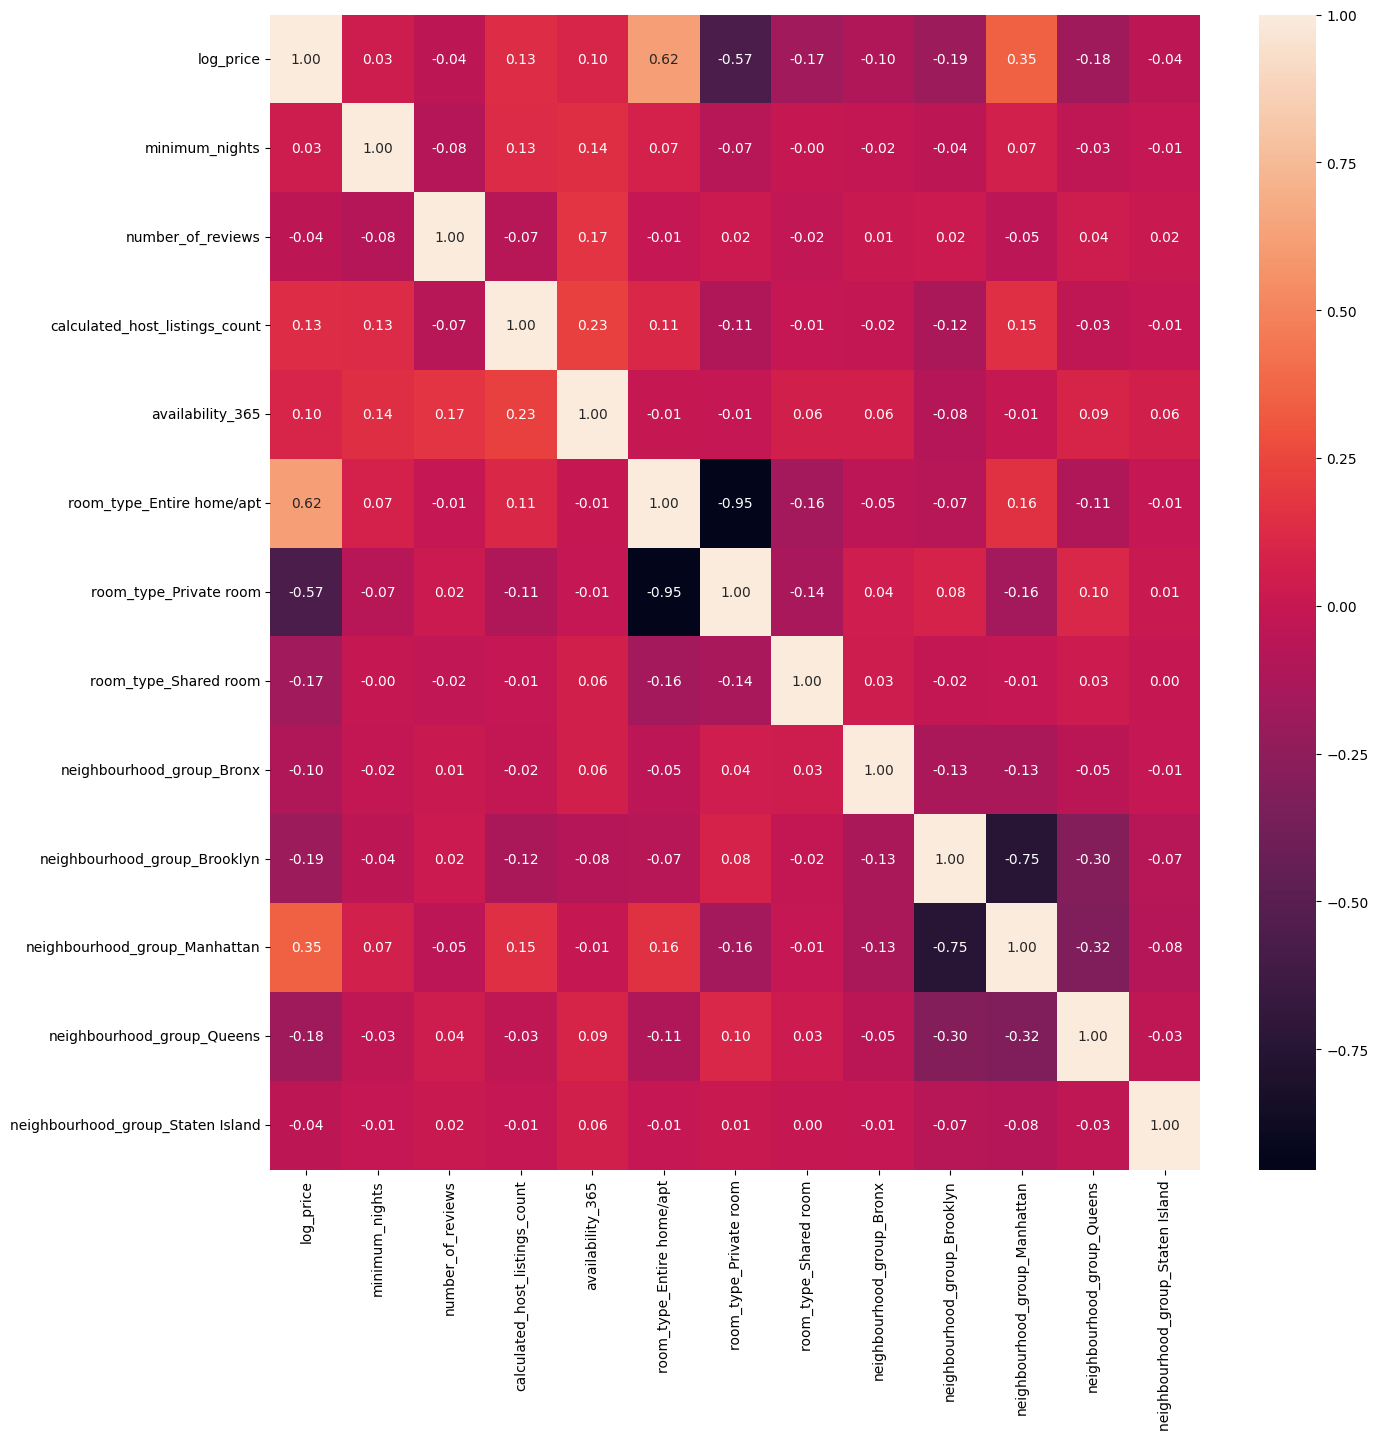

In [40]:
fig, axis = plt.subplots(figsize=(15, 15))

sns.heatmap(ds_categoricas_encoded[var_corr].corr(), annot=True, fmt=".2f", ax=axis).set(ylabel=None)
plt.tight_layout
plt.show()

In [41]:
corr= ds_categoricas_encoded[var_corr].corr()
corr.log_price

log_price                            1.00
minimum_nights                       0.03
number_of_reviews                   -0.04
calculated_host_listings_count       0.13
availability_365                     0.10
room_type_Entire home/apt            0.62
room_type_Private room              -0.57
room_type_Shared room               -0.17
neighbourhood_group_Bronx           -0.10
neighbourhood_group_Brooklyn        -0.19
neighbourhood_group_Manhattan        0.35
neighbourhood_group_Queens          -0.18
neighbourhood_group_Staten Island   -0.04
Name: log_price, dtype: float64

El precio tiene correlación positiva significativa con los alquileres de Manhattan (.35) (aumenta el precio si la vivienda están en Manhattan), y con los tipos de alquileres de pisos enteros (.62) (lo cual hace mucho sentido que un piso entero represente precios más altos).

Negativamente esta ligeramente correlacionado con las viviendas de Broklyn y Queens (estas viviendas tienen a tener un precio más bajo), aunque no es una correlación particularmente significativa. 

In [42]:
#Detección de Multicolinealidad en las Variables: 

vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index= ds_categoricas_encoded[var_corr].columns)
vif

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


log_price                            2.56e+09
minimum_nights                       3.73e+06
number_of_reviews                    3.72e+06
calculated_host_listings_count       8.09e+03
availability_365                     2.72e+07
room_type_Entire home/apt            2.54e+13
room_type_Private room               3.19e+13
room_type_Shared room                1.29e+15
neighbourhood_group_Bronx                 inf
neighbourhood_group_Brooklyn         9.01e+15
neighbourhood_group_Manhattan             inf
neighbourhood_group_Queens           4.50e+15
neighbourhood_group_Staten Island         inf
dtype: float64

Las variables categóricas presentan alto colinearidad pero esto no refleja un índice de inflación de la varianza preciso ya que han sido aplicadas con One-Hot y las columnas binarias estas obviamente relacionadas entre si.

Búsqueda y Tratamiento de Outliers: 

In [43]:
ds.columns
var_num = []

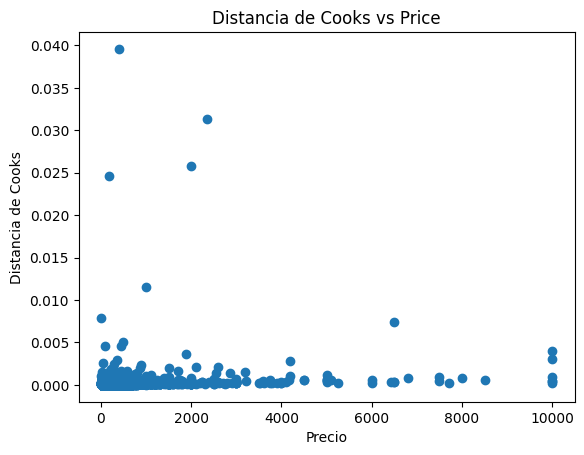

In [44]:
ds.columns
var_num = ["latitude","longitude","minimum_nights", "number_of_reviews", "calculated_host_listings_count", "availability_365" ]

# Búsqueda de Observaciones Influyentes (Valores Atípicos / Outliers) mediante la Distancia de Cook



#Definición de Variables: v. predictoras (X) / v. objetivo (Y)
x = ds[var_num]  # Variables Predictorias
y= ds["log_price"]  # Variable Dependiente / Objetivo

# Ajuste al Modelo:                
x = sm.add_constant(x)          
modelo = sm.OLS(y, x).fit()


# Instancia de la influencia y cálculo de la Distancia de Cook
distancia_cook = modelo.get_influence().cooks_distance


#Plotear los resultados
plt.scatter(x=ds.price, y=distancia_cook[0]) # No termino de entender por qué se pone el [0]
plt.title("Distancia de Cooks vs Price")
plt.xlabel("Precio")
plt.ylabel("Distancia de Cooks")
plt.show()

In [45]:
#busco las posiciones de los valores atípicos:
np.where(distancia_cook[0] > 0.020)

(array([ 2854,  5767, 17811, 44418]),)

In [46]:
ds.iloc[44418]

host_id                                9295237
neighbourhood_group                     Queens
neighbourhood                          Astoria
latitude                                 40.76
longitude                               -73.91
room_type                         Private room
price                                     2000
minimum_nights                             365
number_of_reviews                            0
reviews_per_month                         1.37
calculated_host_listings_count               2
availability_365                             0
log_price                                  7.6
Name: 44429, dtype: object

In [47]:
ds.iloc[2854]

host_id                                     6676776
neighbourhood_group                       Manhattan
neighbourhood                     Battery Park City
latitude                                      40.71
longitude                                    -74.02
room_type                           Entire home/apt
price                                           400
minimum_nights                                 1000
number_of_reviews                                 0
reviews_per_month                              1.37
calculated_host_listings_count                    1
availability_365                                362
log_price                                      5.99
Name: 2854, dtype: object

In [48]:
ds.iloc[17811]

host_id                                  41870118
neighbourhood_group                        Queens
neighbourhood                        Forest Hills
latitude                                    40.72
longitude                                  -73.84
room_type                         Entire home/apt
price                                        2350
minimum_nights                                365
number_of_reviews                               0
reviews_per_month                            1.37
calculated_host_listings_count                  1
availability_365                              364
log_price                                    7.76
Name: 17811, dtype: object

In [49]:
#Elimino las filas con estos valores outliers
ds.drop([44418, 5767, 2854,17811], axis=0, inplace=True)

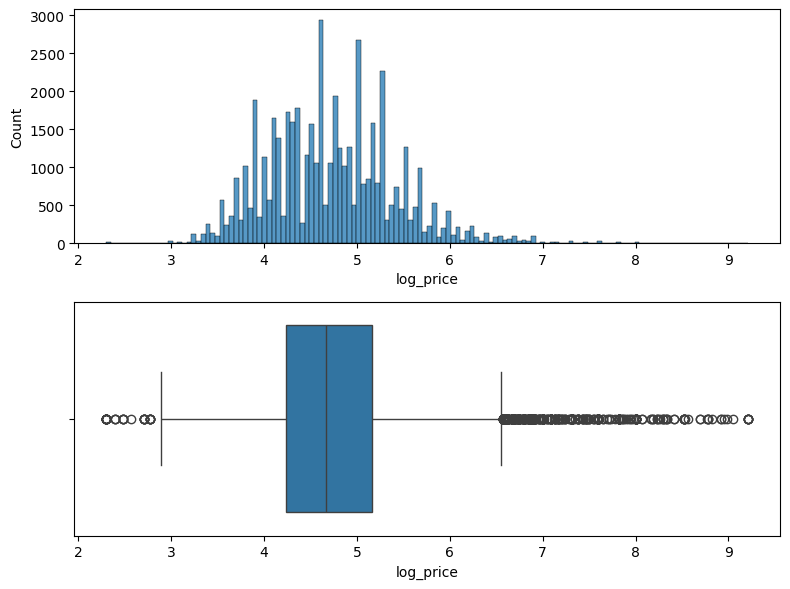

In [50]:
fig, axis = plt.subplots(2, figsize=(8,6))

sns.histplot(ax=axis[0], data= ds, x= "log_price")
sns.boxplot(ax=axis[1], data=ds, x="log_price")

plt.tight_layout()
plt.show()

In [55]:
price_data = ds["log_price"].describe()
price_data

count    48880.00
mean         4.73
std          0.70
min          2.30
25%          4.23
50%          4.66
75%          5.16
max          9.21
Name: log_price, dtype: float64

In [56]:

q1 = price_data["25%"]
q3 = price_data["75%"]

iqr_price = q3 - q1
lim_sup = q3 + (iqr_price*1.5)
lim_inf = q1 - (iqr_price*1.5)

print(f"El límite inferior de log_price es {round(lim_inf, 2)}")
print(f"El límite superior de log_price es {round(lim_sup, 2)}")
print(f"El iqr log_price es {round(iqr_price, 2)}")

El límite inferior de log_price es 2.84
El límite superior de log_price es 6.56
El iqr log_price es 0.93


In [84]:
print(f" Cantidad de outliers en log_price: {round(len(ds[ds['log_price'] > lim_sup]), 2)}")
print(f" Porcentaje de outliers en log_price: {round(len(ds[ds['log_price'] > lim_sup]) / len(ds) *100, 2)} %")

 Cantidad de outliers en log_price: 588
 Porcentaje de outliers en log_price: 1.2 %


In [68]:
print(ds[ds["log_price"] > lim_sup]["room_type"].value_counts())

room_type
Entire home/apt    484
Private room        96
Shared room          8
Name: count, dtype: int64


In [69]:
print(ds[ds["log_price"] > lim_sup]["neighbourhood_group"].value_counts())

neighbourhood_group
Manhattan        441
Brooklyn         123
Queens            17
Staten Island      4
Bronx              3
Name: count, dtype: int64


In [77]:
ds[(ds["log_price"] > lim_sup) & (ds["neighbourhood_group"] == "Manhattan") & (ds["room_type"] == "Entire home/apt")]

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_price
496,836168,Manhattan,Upper West Side,40.77,-73.99,Entire home/apt,2000,30,30,0.33,11,0,7.60
662,1314834,Manhattan,Greenwich Village,40.73,-74.00,Entire home/apt,850,3,107,1.15,1,249,6.75
691,1347034,Manhattan,Chelsea,40.75,-74.00,Entire home/apt,760,2,7,0.08,1,361,6.63
762,605463,Manhattan,West Village,40.73,-74.00,Entire home/apt,1300,5,28,0.31,4,297,7.17
1414,836168,Manhattan,Upper West Side,40.77,-73.99,Entire home/apt,1000,30,44,0.53,11,364,6.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48080,203565865,Manhattan,SoHo,40.72,-74.00,Entire home/apt,1308,2,0,1.37,1,179,7.18
48304,270214015,Manhattan,Hell's Kitchen,40.76,-74.00,Entire home/apt,2999,30,0,1.37,1,222,8.01
48305,272166348,Manhattan,Upper East Side,40.78,-73.95,Entire home/apt,1999,30,0,1.37,1,270,7.60
48343,5723770,Manhattan,Chelsea,40.75,-74.00,Entire home/apt,750,1,0,1.37,1,89,6.62


In [89]:
round(len(ds[(ds['log_price'] > lim_sup) & (ds['neighbourhood_group'] == 'Manhattan') & (ds['room_type'] == 'Entire home/apt')]) / len(ds[ds['log_price'] > lim_sup])*100,2)

63.95

In [91]:
print(f"Sobre el total de Outliers ({round(len(ds[ds['log_price'] > lim_sup]), 2)}), el {round(len(ds[(ds['log_price'] > lim_sup) & (ds['neighbourhood_group'] == 'Manhattan') & (ds['room_type'] == 'Entire home/apt')]) / len(ds[ds['log_price'] > lim_sup])*100,2)} % corresponden a publicaciones de pisos enteros en Manhattan")

Sobre el total de Outliers (588), el 63.95 % corresponden a publicaciones de pisos enteros en Manhattan


En el sentido de este último cálculo, las publiciones con precios con valores atípicos, podrían verse influidos por las Variables de neighbourhood_group' == 'Manhattan y de 'room_type' == 'Entire home/apt'.

Además justamente estas categorías habían mostrado tener una correlación positiva con el precio.

Como los outliers podrían manifestar este patron y verse influidos por estas características, para no negarle este valor predictivo al modelo, aplico winsorización.

In [96]:
ds[["price", "log_price"]].skew()

price        19.15
log_price     0.61
dtype: float64

In [98]:
price_data = ds["log_price"].describe()
price_data

count    48880.00
mean         4.73
std          0.70
min          2.30
25%          4.23
50%          4.66
75%          5.16
max          9.21
Name: log_price, dtype: float64

In [117]:
def winzorizar_columna(columna, lower, upper):
    q1 = columna.quantile(lower)
    q3 = columna.quantile(upper)
    iqr_value = q3 - q1
    lim_inf = q1 - 1.5 * iqr_value
    lim_sup = q3 + 1.5 * iqr_value
    columna = columna.clip(lower=lim_inf, upper=lim_sup)
    
    return columna


for column in ds[["log_price", "price"]]:
    ds[column] = winzorizar_columna(ds[column], 0.25, 0.75)


In [122]:
ds[ds.log_price > lim_sup].count()

host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
log_price                         0
dtype: int64

In [123]:
ds.log_price.describe()

count    48880.00
mean         4.72
std          0.67
min          2.84
25%          4.23
50%          4.66
75%          5.16
max          6.56
Name: log_price, dtype: float64